In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
# Load metadata and classes
metadata = pd.read_csv("metadata.csv")
classes = pd.read_csv("class_dict.csv")



In [8]:
# Limit metadata for example (optional)
metadata = metadata.head(802)


In [9]:
# Create a class dictionary mapping RGB to class names
class_dict = {tuple(row[1:4]): row[0] for row in classes.itertuples(index=False)}


In [10]:
# Function to get RGB to class name mapping
def get_rgb_mapping(classes):
    rgb_mapping = {}
    for index, row in classes.iterrows():
        rgb_mapping[(row['r'], row['g'], row['b'])] = row['name']
    return rgb_mapping

# Function to convert RGB mask to categorical mask
def rgb_to_categorical_mask(rgb_image, class_dict):
    categorical_mask = np.zeros(rgb_image.shape[:2], dtype=np.uint8)
    
    for idx, (rgb, name) in enumerate(class_dict.items()):
        mask = (rgb_image[..., 0] == rgb[0]) & (rgb_image[..., 1] == rgb[1]) & (rgb_image[..., 2] == rgb[2])
        categorical_mask[mask] = idx
    
    return categorical_mask


In [11]:
# PyTorch Dataset class
class SatelliteDataset(Dataset):
    def __init__(self, metadata, class_dict, img_size=(128, 128), transform=None):
        self.metadata = metadata
        self.class_dict = class_dict
        self.img_size = img_size
        self.transform = transform
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        # Load and resize the satellite image
        img = Image.open(row['sat_image_path']).resize(self.img_size)
        img = np.array(img) / 255.0  # Normalize
        
        # Load and resize the mask, then convert it to categorical format
        mask = Image.open(row['mask_path']).resize(self.img_size)
        mask = rgb_to_categorical_mask(np.array(mask), self.class_dict)
        
        if self.transform:
            img = self.transform(img)
            mask = torch.tensor(mask, dtype=torch.long)
        
        return img, mask


In [12]:
# Load dataset and split into train/validation
transform = transforms.ToTensor()
dataset = SatelliteDataset(metadata, class_dict, img_size=(128, 128), transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [13]:
# Residual Block Definition
class ResidualBlock(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        self.skip = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

    def forward(self, x):
        conv = self.conv(x)
        skip = self.skip(x)
        return conv + skip

# U-Net Model with Residual Blocks
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = ResidualBlock(3, 64)
        self.dconv_down2 = ResidualBlock(64, 128)
        self.dconv_down3 = ResidualBlock(128, 256)
        self.dconv_down4 = ResidualBlock(256, 512)
        self.bottleneck = ResidualBlock(512, 1024)        

        self.maxpool = nn.MaxPool2d(2)

        self.dconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)        
        self.dconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dconv_up4 = ResidualBlock(1024, 512) 
        self.dconv_up3 = ResidualBlock(512, 256)
        self.dconv_up2 = ResidualBlock(256, 128)
        self.dconv_up1 = ResidualBlock(128, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        x1 = self.maxpool(conv1) 

        conv2 = self.dconv_down2(x1)
        x2 = self.maxpool(conv2) 
        
        conv3 = self.dconv_down3(x2)
        x3 = self.maxpool(conv3) 

        conv4 = self.dconv_down4(x3)
        x4 = self.maxpool(conv4)         

        x5 = self.bottleneck(x4) 

        # Decoder
        x = self.dconv1(x5)        
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)

        x = self.dconv2(x)        
        x = torch.cat([x, conv3], dim=1)       
        x = self.dconv_up3(x)

        x = self.dconv3(x)        
        x = torch.cat([x, conv2], dim=1)   
        x = self.dconv_up2(x)

        x = self.dconv4(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        
        seg = self.conv_last(x)
        return seg


In [14]:
# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss


In [15]:
# Initialize the model, loss, and optimizer
model = UNet(n_class=len(class_dict)).to(device)
criterion = FocalLoss(alpha=1, gamma=2)  # Using Focal Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [1]:
# Training Loop
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50):
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for images, masks in train_loader:
                images, masks = images.to(device).float(), masks.to(device).long()  # Convert masks to Long
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * images.size(0)

                pbar.set_postfix({'loss': loss.item()})
                pbar.update(1)
            
        train_loss /= len(train_loader.dataset)
        
        # Validation phase with progress bar
        model.eval()
        val_loss = 0.0
        
        with tqdm(total=len(val_loader), desc=f"Validation Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(device).float(), masks.to(device).long()  # Convert masks to Long
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    val_loss += loss.item() * images.size(0)

                    pbar.set_postfix({'loss': loss.item()})
                    pbar.update(1)
        
        val_loss /= len(val_loader.dataset)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        # Save model if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Best model saved with validation loss: {best_loss:.4f}")

train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50)


Validation Epoch 1/50: 100%|█████████████████████████████████████████████| 11/11 [00:36<00:00,  3.28s/batch, loss=3.33]


Epoch 1/50, Train Loss: 1.2444, Validation Loss: 1.2920
Best model saved with validation loss: 1.2920


Validation Epoch 2/50: 100%|█████████████████████████████████████████████| 11/11 [00:36<00:00,  3.33s/batch, loss=1.08]


Epoch 2/50, Train Loss: 0.7213, Validation Loss: 0.5084
Best model saved with validation loss: 0.5084


Validation Epoch 3/50: 100%|████████████████████████████████████████████| 11/11 [00:38<00:00,  3.50s/batch, loss=0.876]


Epoch 3/50, Train Loss: 0.5056, Validation Loss: 0.4601
Best model saved with validation loss: 0.4601


Validation Epoch 4/50: 100%|████████████████████████████████████████████| 11/11 [00:36<00:00,  3.28s/batch, loss=0.708]


Epoch 4/50, Train Loss: 0.4390, Validation Loss: 0.3485
Best model saved with validation loss: 0.3485


Validation Epoch 5/50: 100%|████████████████████████████████████████████| 11/11 [00:37<00:00,  3.45s/batch, loss=0.833]


Epoch 5/50, Train Loss: 0.4065, Validation Loss: 0.3889


Validation Epoch 6/50: 100%|████████████████████████████████████████████| 11/11 [00:36<00:00,  3.27s/batch, loss=0.684]


Epoch 6/50, Train Loss: 0.3844, Validation Loss: 0.3043
Best model saved with validation loss: 0.3043


Validation Epoch 7/50: 100%|█████████████████████████████████████████████| 11/11 [00:35<00:00,  3.24s/batch, loss=0.62]


Epoch 7/50, Train Loss: 0.3185, Validation Loss: 0.2913
Best model saved with validation loss: 0.2913


Validation Epoch 8/50: 100%|████████████████████████████████████████████| 11/11 [00:34<00:00,  3.14s/batch, loss=0.602]


Epoch 8/50, Train Loss: 0.2963, Validation Loss: 0.2416
Best model saved with validation loss: 0.2416


Validation Epoch 9/50: 100%|████████████████████████████████████████████| 11/11 [00:34<00:00,  3.17s/batch, loss=0.639]


Epoch 9/50, Train Loss: 0.3097, Validation Loss: 0.2475


Validation Epoch 10/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.22s/batch, loss=0.614]


Epoch 10/50, Train Loss: 0.2663, Validation Loss: 0.2815


Validation Epoch 11/50: 100%|████████████████████████████████████████████| 11/11 [00:35<00:00,  3.23s/batch, loss=0.58]


Epoch 11/50, Train Loss: 0.2959, Validation Loss: 0.2415
Best model saved with validation loss: 0.2415


Validation Epoch 12/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.22s/batch, loss=0.579]


Epoch 12/50, Train Loss: 0.2557, Validation Loss: 0.2170
Best model saved with validation loss: 0.2170


Validation Epoch 13/50: 100%|████████████████████████████████████████████| 11/11 [00:35<00:00,  3.18s/batch, loss=0.59]


Epoch 13/50, Train Loss: 0.2212, Validation Loss: 0.2073
Best model saved with validation loss: 0.2073


Validation Epoch 14/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.19s/batch, loss=0.819]


Epoch 14/50, Train Loss: 0.2486, Validation Loss: 0.2112


Validation Epoch 15/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.18s/batch, loss=0.553]


Epoch 15/50, Train Loss: 0.2140, Validation Loss: 0.1669
Best model saved with validation loss: 0.1669


Validation Epoch 16/50: 100%|███████████████████████████████████████████| 11/11 [00:36<00:00,  3.28s/batch, loss=0.455]


Epoch 16/50, Train Loss: 0.2099, Validation Loss: 0.2117


Validation Epoch 17/50: 100%|████████████████████████████████████████████| 11/11 [00:35<00:00,  3.25s/batch, loss=0.68]


Epoch 17/50, Train Loss: 0.2105, Validation Loss: 0.1714


Validation Epoch 18/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.21s/batch, loss=0.584]


Epoch 18/50, Train Loss: 0.2013, Validation Loss: 0.2395


Validation Epoch 19/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.19s/batch, loss=0.397]


Epoch 19/50, Train Loss: 0.1802, Validation Loss: 0.2321


Validation Epoch 20/50: 100%|████████████████████████████████████████████| 11/11 [00:35<00:00,  3.20s/batch, loss=0.47]


Epoch 20/50, Train Loss: 0.1712, Validation Loss: 0.1749


Validation Epoch 21/50: 100%|███████████████████████████████████████████| 11/11 [00:34<00:00,  3.13s/batch, loss=0.433]


Epoch 21/50, Train Loss: 0.1792, Validation Loss: 0.2500


Validation Epoch 22/50: 100%|███████████████████████████████████████████| 11/11 [00:34<00:00,  3.17s/batch, loss=0.395]


Epoch 22/50, Train Loss: 0.1728, Validation Loss: 0.1494
Best model saved with validation loss: 0.1494


Validation Epoch 23/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.20s/batch, loss=0.341]


Epoch 23/50, Train Loss: 0.1580, Validation Loss: 0.1933


Validation Epoch 24/50: 100%|███████████████████████████████████████████| 11/11 [00:36<00:00,  3.28s/batch, loss=0.347]


Epoch 24/50, Train Loss: 0.1519, Validation Loss: 0.1566


Validation Epoch 25/50: 100%|████████████████████████████████████████████| 11/11 [00:35<00:00,  3.21s/batch, loss=0.43]


Epoch 25/50, Train Loss: 0.1689, Validation Loss: 0.3536


Validation Epoch 26/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.18s/batch, loss=0.832]


Epoch 26/50, Train Loss: 0.2892, Validation Loss: 0.2361


Validation Epoch 27/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.19s/batch, loss=0.438]


Epoch 27/50, Train Loss: 0.2202, Validation Loss: 0.1795


Validation Epoch 28/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.21s/batch, loss=0.427]


Epoch 28/50, Train Loss: 0.1994, Validation Loss: 0.2506


Validation Epoch 29/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.18s/batch, loss=0.303]


Epoch 29/50, Train Loss: 0.1878, Validation Loss: 0.2300


Validation Epoch 30/50: 100%|████████████████████████████████████████████| 11/11 [00:34<00:00,  3.16s/batch, loss=0.38]


Epoch 30/50, Train Loss: 0.1689, Validation Loss: 0.2346


Validation Epoch 31/50: 100%|████████████████████████████████████████████| 11/11 [00:34<00:00,  3.13s/batch, loss=1.02]


Epoch 31/50, Train Loss: 0.1583, Validation Loss: 0.1763


Validation Epoch 32/50: 100%|███████████████████████████████████████████| 11/11 [00:34<00:00,  3.17s/batch, loss=0.292]


Epoch 32/50, Train Loss: 0.1557, Validation Loss: 0.1797


Validation Epoch 33/50: 100%|███████████████████████████████████████████| 11/11 [00:34<00:00,  3.16s/batch, loss=0.267]


Epoch 33/50, Train Loss: 0.1298, Validation Loss: 0.1424
Best model saved with validation loss: 0.1424


Validation Epoch 34/50: 100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.18s/batch, loss=0.264]


Epoch 34/50, Train Loss: 0.1298, Validation Loss: 0.1463


Validation Epoch 35/50: 100%|███████████████████████████████████████████| 11/11 [00:34<00:00,  3.13s/batch, loss=0.228]


Epoch 35/50, Train Loss: 0.1352, Validation Loss: 0.1338
Best model saved with validation loss: 0.1338


Validation Epoch 36/50: 100%|███████████████████████████████████████████| 11/11 [00:38<00:00,  3.47s/batch, loss=0.332]


Epoch 36/50, Train Loss: 0.1362, Validation Loss: 0.1736


Validation Epoch 37/50: 100%|████████████████████████████████████████████| 11/11 [00:37<00:00,  3.39s/batch, loss=0.28]


Epoch 37/50, Train Loss: 0.1536, Validation Loss: 0.1828


Validation Epoch 38/50: 100%|███████████████████████████████████████████| 11/11 [00:38<00:00,  3.54s/batch, loss=0.353]


Epoch 38/50, Train Loss: 0.1276, Validation Loss: 0.1470


Validation Epoch 39/50: 100%|███████████████████████████████████████████| 11/11 [00:37<00:00,  3.43s/batch, loss=0.324]


Epoch 39/50, Train Loss: 0.1249, Validation Loss: 0.1770


Validation Epoch 40/50: 100%|███████████████████████████████████████████| 11/11 [00:37<00:00,  3.40s/batch, loss=0.275]


Epoch 40/50, Train Loss: 0.1257, Validation Loss: 0.1289
Best model saved with validation loss: 0.1289


Validation Epoch 41/50: 100%|████████████████████████████████████████████| 11/11 [00:39<00:00,  3.62s/batch, loss=0.28]


Epoch 41/50, Train Loss: 0.1135, Validation Loss: 0.1313


Validation Epoch 42/50: 100%|███████████████████████████████████████████| 11/11 [00:37<00:00,  3.45s/batch, loss=0.278]


Epoch 42/50, Train Loss: 0.1072, Validation Loss: 0.1273
Best model saved with validation loss: 0.1273


Validation Epoch 43/50: 100%|███████████████████████████████████████████| 11/11 [00:40<00:00,  3.65s/batch, loss=0.204]


Epoch 43/50, Train Loss: 0.1017, Validation Loss: 0.1372


Validation Epoch 44/50: 100%|███████████████████████████████████████████| 11/11 [00:36<00:00,  3.35s/batch, loss=0.325]


Epoch 44/50, Train Loss: 0.1044, Validation Loss: 0.1518


Validation Epoch 45/50: 100%|███████████████████████████████████████████| 11/11 [00:38<00:00,  3.54s/batch, loss=0.356]


Epoch 45/50, Train Loss: 0.1094, Validation Loss: 0.1551


Validation Epoch 46/50: 100%|███████████████████████████████████████████| 11/11 [00:40<00:00,  3.72s/batch, loss=0.237]


Epoch 46/50, Train Loss: 0.1102, Validation Loss: 0.1236
Best model saved with validation loss: 0.1236


Validation Epoch 47/50: 100%|███████████████████████████████████████████| 11/11 [00:43<00:00,  3.94s/batch, loss=0.337]


Epoch 47/50, Train Loss: 0.0920, Validation Loss: 0.1303


Validation Epoch 48/50: 100%|███████████████████████████████████████████| 11/11 [00:43<00:00,  3.93s/batch, loss=0.393]


Epoch 48/50, Train Loss: 0.1212, Validation Loss: 0.1296


Validation Epoch 49/50: 100%|███████████████████████████████████████████| 11/11 [00:45<00:00,  4.17s/batch, loss=0.449]


Epoch 49/50, Train Loss: 0.1065, Validation Loss: 0.1314


Validation Epoch 50/50: 100%|████████████████████████████████████████████| 11/11 [00:47<00:00,  4.29s/batch, loss=0.35]

Epoch 50/50, Train Loss: 0.0987, Validation Loss: 0.2733


In [27]:
model = UNet(n_class=len(class_dict)).to(device)

# Load the saved weights
model.load_state_dict(torch.load('best_model.pth', map_location=device))

# Switch the model to evaluation mode
model.eval()

print("Model loaded successfully!")


Model loaded successfully!


In [28]:
from sklearn.metrics import jaccard_score
import numpy as np

# Function to calculate IoU
def calculate_iou(pred_mask, true_mask, num_classes):
    pred_mask = pred_mask.flatten()
    true_mask = true_mask.flatten()

    # IoU calculation per class
    iou_per_class = []
    for cls in range(num_classes):
        intersection = np.sum((pred_mask == cls) & (true_mask == cls))
        union = np.sum((pred_mask == cls) | (true_mask == cls))
        if union == 0:
            iou_per_class.append(np.nan)  # No instances of this class
        else:
            iou_per_class.append(intersection / union)
    
    # Average IoU over all classes
    mean_iou = np.nanmean(iou_per_class)
    return mean_iou

# Function to calculate Pixel Accuracy
def calculate_pixel_accuracy(pred_mask, true_mask):
    correct_pixels = np.sum(pred_mask == true_mask)
    total_pixels = pred_mask.size
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

# Validation loop to calculate metrics
def evaluate_model(model, val_loader, num_classes):
    model.eval()
    iou_scores = []
    pixel_accuracies = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Evaluating", unit="batch"):
            images = images.to(device).float()
            masks = masks.to(device).long()
            
            # Predict
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Convert to class predictions
            
            # Calculate metrics for each batch
            preds_np = preds.cpu().numpy()
            masks_np = masks.cpu().numpy()
            
            for pred, true in zip(preds_np, masks_np):
                iou_scores.append(calculate_iou(pred, true, num_classes))
                pixel_accuracies.append(calculate_pixel_accuracy(pred, true))
    
    # Report metrics
    mean_iou = np.nanmean(iou_scores)
    mean_pixel_accuracy = np.mean(pixel_accuracies)
    
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")

# Evaluate the model
evaluate_model(model, val_loader, num_classes=len(classes))


Evaluating: 100%|███████████████████████████████████████████████████████████████████| 11/11 [00:36<00:00,  3.30s/batch]

Mean IoU: 0.3147
Mean Pixel Accuracy: 0.8302


In [29]:
def predict_deforestation(image_path, model, class_dict, img_size=(128, 128)):
    # Load and preprocess the image
    image = Image.open(image_path).resize(img_size)
    image = np.array(image) / 255.0
    image_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).to(device).float()
    
    # Predict using the model
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    # Map categorical classes back to RGB
    rgb_mask = np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8)
    for rgb, idx in class_dict.items():
        rgb_mask[predicted_mask == idx] = rgb
    
    return rgb_mask, predicted_mask



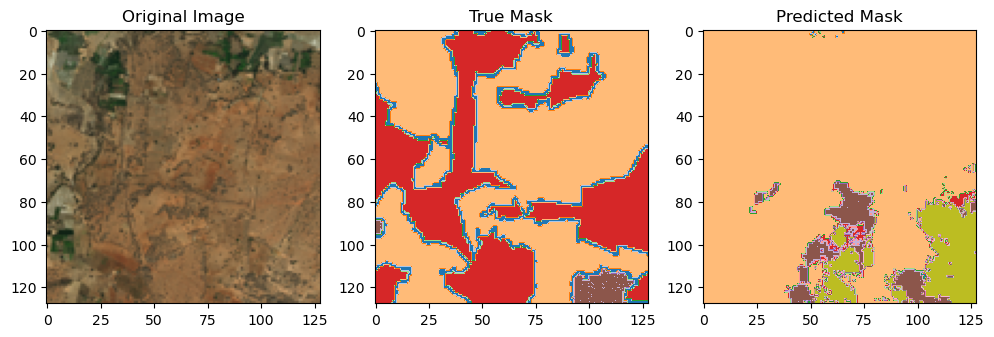

In [33]:
def visualize_predictions(model, dataset, idx=10):
    model.eval()
    img, true_mask = dataset[idx]
    
    # Ensure image is in the correct type
    img = img.unsqueeze(0).to(device).float()  # Convert to float32
    
    with torch.no_grad():
        pred_mask = model(img)
        pred_mask = torch.argmax(pred_mask.squeeze(), dim=0).cpu().numpy()
    
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)
    true_mask = true_mask.numpy()
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='tab20', vmin=0, vmax=len(classes) - 1)
    plt.title('True Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='tab20', vmin=0, vmax=len(classes) - 1)
    plt.title('Predicted Mask')
    plt.show()

# Visualize a sample prediction
visualize_predictions(model, dataset, idx=10)


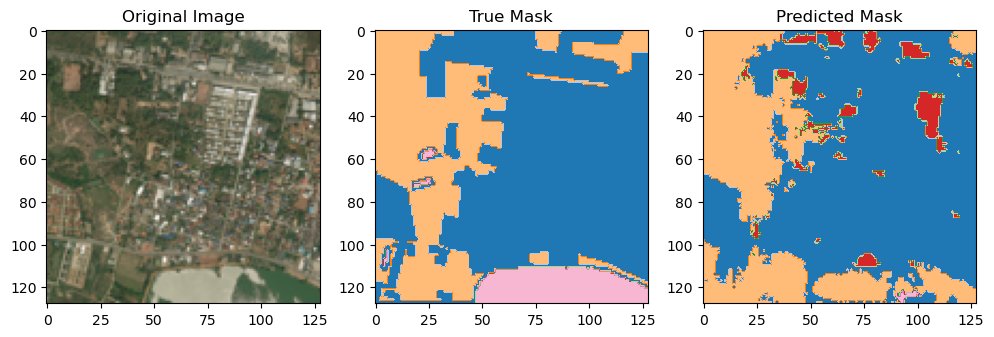

In [35]:
visualize_predictions(model, dataset, idx=12)


In [38]:
rgb_mask, predicted_mask=predict_deforestation('test/1499_sat.jpg', model, class_dict, img_size=(128, 128))

In [39]:
def calculate_deforestation_area(pred_mask, pixel_area):
    # Define the class index for deforestation
    deforestation_class_index = 1  

    # Count the number of pixels classified as deforestation
    deforested_pixels = np.sum(pred_mask == deforestation_class_index)
    
    # Calculate the total area affected by deforestation
    total_deforestation_area = deforested_pixels * pixel_area
    return total_deforestation_area

# Define the area represented by each pixel (in square meters)
pixel_area = 30 * 30

# Calculate the deforestation area
deforestation_area = calculate_deforestation_area(predicted_mask, pixel_area)

print(f"Total area affected by deforestation: {deforestation_area:.2f} square meters")


Total area affected by deforestation: 14404500.00 square meters
